<img src="https://kenya.ai/wp-content/uploads/2020/05/Mckinsey-prohack.png" width="1000px"> 




# International Data Science Hackathon by McKinsey & Company



**by team GORNYAKI (Tsepa Oleksii and Samoshin Andriy [Ukraine, KPI, IASA])**

Thanks to the organizers for this hackathon and everyone for participating! In this notebook we will go through the first part of our team solution:

* **data exploration**
* **missing values**
* **categorical features**
* **and other issues**

For those who hear about this competition for the first time, you can familiarize yourself with the condition [here](https://prohack.org/). All data is located [here](https://www.kaggle.com/mrmorj/prohack-hackathon).

[The second part, where we talk about our models and the optimization task](https://www.kaggle.com/imgremlin/prohack-part-2-fe-modeling-optimization)

# Data Exploration

So let's turn to the code

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.set_option('chained_assignment',None)

seed=47

train = pd.read_csv('/kaggle/input/prohack-hackathon/train.csv')
test = pd.read_csv('/kaggle/input/prohack-hackathon/test.csv')
sample_submit = pd.read_csv('/kaggle/input/prohack-hackathon/sample_submit.csv')

total_df_fillna = pd.concat([train, test], ignore_index=True)

print(train.shape, test.shape)

In [ ]:
total_df_fillna

In [ ]:
total_df_fillna.describe()

In [ ]:
print('Unique galaxies:', total_df_fillna['galaxy'].nunique())
print('Number of years:', total_df_fillna['galactic year'].nunique())

total_df_fillna.drop(['galactic year','galaxy','y'],axis=1, inplace=True)

**In total**:
* we have 79 features (in the second part we will select features)
* many unique galaxies
* and 27 years during which statistics was kept
* different scales of features. It will be necessary to use scalers
* our data contains many outliers

# Missing values

In [ ]:
import missingno as msno 
msno.matrix(total_df_fillna[list(total_df_fillna.columns)[:]])
print('Train missing values:', train.isna().sum().sum())
print('Test missing values:', test.isna().sum().sum())

The first problem we are facing: **there is a lot of missing data**. In the initial stages of the solution, perhaps, many teams tried to use **interpolation**. We also started with her, but she did not give a good result.

Moreover, there are many countries in which entire columns of data are missing *(example below)*, so interpolation there will not help exactly.

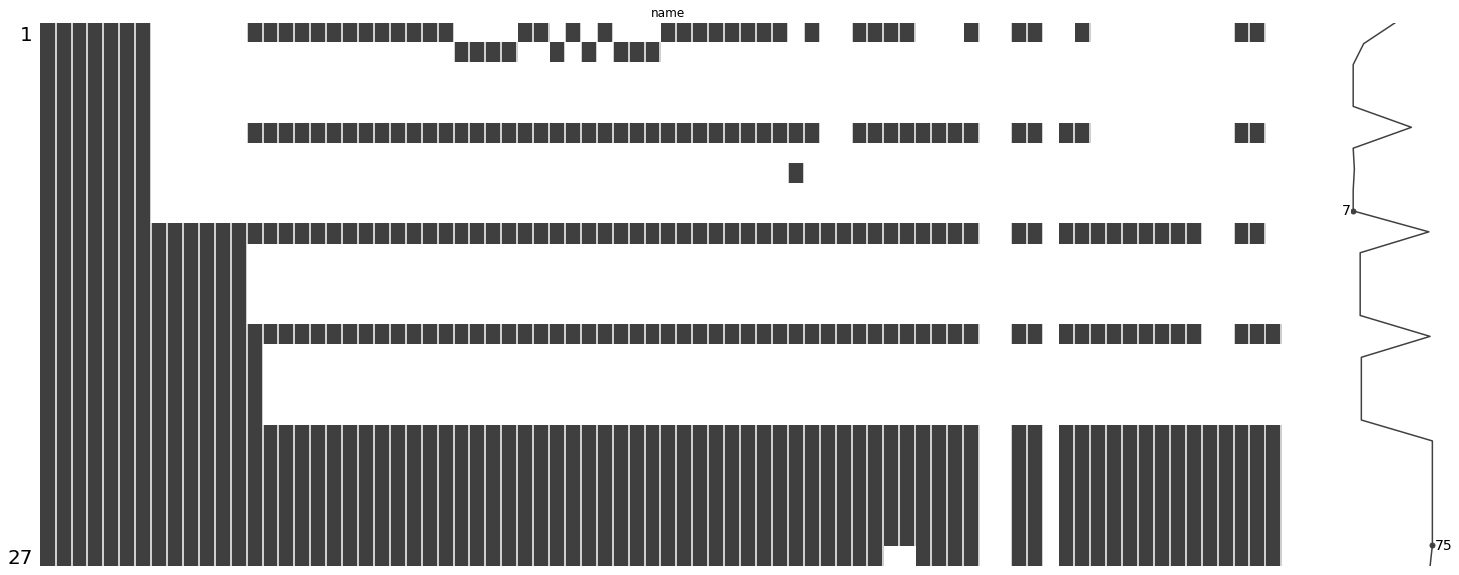

We decided to use **ElasticNet** to fill in the missing data. 

**The algorithm is as follows:**
1. Delete the missing data and build the correlation matrix
2. We fix each feature (this will be our target in this case) and select high correlated feature. We will use them for training model and predicting target.
3. We run through all the features

*It was also not possible to try to fill in the missing values directly using the formulas of various indices, but many functions could not be calculated using ready-made formulas (for example, the number of women in the Senate). Moreover, if we substitute the known data into the formulas, then they did not always coincide.*

In [ ]:
import pickle
from sklearn.linear_model import ElasticNet

test_na = test.dropna()
train_na = train.dropna()
total_df = pd.concat([train_na, test_na], ignore_index=True)
total_df.drop(['galactic year','galaxy','y'],axis=1, inplace=True)

corrMatrix = total_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrMatrix, annot=False)
plt.show()

koef_corr = 0.65
koef_na = 0.8
top_features = 5
num_model = 1
list_target_features = []
list_corr_features = []

for big_col in list(total_df.columns):
    list_correlated=[]
    correlations=[]
    na_rows=[]
    na_big_col= total_df_fillna[big_col].isna().sum()

    for col in list(total_df.columns):
        cor = total_df[big_col].corr(total_df[col])

        if np.absolute(cor)>koef_corr and np.absolute(cor)<0.99:
            list_correlated.append(col)
            correlations.append(np.absolute(cor))
            na_rows.append(total_df_fillna[col].isna().sum())
            df = pd.DataFrame(list(zip(list_correlated, correlations,na_rows)),columns =['features', 'correlation', 'na']) 

    df = df[df.na<koef_na*na_big_col].sort_values(by='correlation', ascending=False)
    list_correlated = list(df[:top_features].features)

    if len(list_correlated)>0:
        list_target_features.append(big_col)
        list_corr_features.append(list_correlated)
        model = ElasticNet(random_state = seed)     
        model.fit(total_df[list_correlated], total_df[big_col])
        pkl_filename = "pickle_model_%i.pkl"%len(list_target_features)
        with open(pkl_filename, 'wb') as file:
            pickle.dump(model, file)
        num_model = num_model + 1

In [ ]:
for i in range(len(list_target_features)):
    target = list_target_features[i]
    corr_feat = list_corr_features[i]

    with open("pickle_model_%i.pkl"%(i+1), 'rb') as file:
        pickle_model = pickle.load(file)

    for i in range(len(total_df_fillna.index)):
        time_corr_features = []
        
        for j in range(len(corr_feat)):
            if len(total_df_fillna[corr_feat[j]][i].shape) == 1:
                feat = total_df_fillna[corr_feat[j]][i].values[0]
            else:
                feat = total_df_fillna[corr_feat[j]][i]
            time_corr_features.append(feat)

        if np.isnan(time_corr_features).sum() == 0:
            if np.isnan(total_df_fillna[target][i]) == True:
                pred = pickle_model.predict(np.asarray(time_corr_features).reshape(1,-1))
                total_df_fillna[target][i] = pred

print(total_df_fillna.isna().sum().sum())

Fine! The amount of missing data has decreased **by more than 3 times**. To be sure, you need to check the updated data for cross-validation, but now let's miss it. For the remaining missing values, we used **linear interpolation**. In this situation, due to the fact that the data are given at certain intervals, it best illustrates the dynamics of the features.

In [ ]:
new_train = total_df_fillna[:len(train.index)].reset_index()
new_test = total_df_fillna[len(train.index):].reset_index()

new_train = new_train.join(train[['galactic year','galaxy','y']])
new_test = new_test.join(test[['galactic year','galaxy']])

df = pd.concat([new_train, new_test], ignore_index=True)

df_sort = df.sort_values(by=['galaxy','galactic year'], ascending=True, ignore_index=True)
title_galaxy = list(df['galaxy'].unique())

num_col = df.iloc[:,:-3].columns

total_df = pd.DataFrame()
for name in title_galaxy:
    temp = df[df['galaxy']==name]
    for column in num_col:
        if temp[column].isna().sum()+4<=len(temp):
            temp[column] = temp[column].interpolate(method='linear', limit_direction ='backward')
        if temp[column].isna().sum()<len(temp):
            m = temp[column].mean()
            temp[column]=temp[column].fillna(m)
    total_df = pd.concat([total_df, temp], ignore_index=True)
    
print(total_df.isna().sum().sum())

Great job! The remaining values are filled with the **mean**. You can also try re-doing model training or try to find formulas for calculating these functions. So if you don't want to overfit, we recommend that you do an mean for the all set, and not just for training data.

In [ ]:
for col in total_df.iloc[:,:-3].columns.values:
    mean = total_df[col].mean()
    total_df[col] = total_df[col].fillna(mean)

In [ ]:
train = total_df[:len(train.index)].reset_index()
test = total_df[len(train.index):].reset_index()

train = train.drop(['level_0', 'index'], axis=1)
test = test.drop(['y','index', 'level_0'], axis=1)

# Encoding galaxy names

An underrated step is the encoding of categorical features. There are many unique names for galaxies in the dataset, we need to do something with them.

In [ ]:
total_df['galaxy'].unique()

Since there are a lot of galaxies, using get_dummies is rather irrational, as there will be a significant increase in dimension. To convert categorical functions, we used the **CatBoost Encoder**.

> Catboost is a recently created target-based categorical encoder. It is intended to overcome target leakage problems inherent in LOO. In order to do that, the authors of Catboost introduced the idea of “time”: the order of observations in the dataset. Clearly, the values of the target statistic for each example rely only on the observed history. To calculate the statistic for observation j in train dataset, we may use only observations, which are collected before observation j, i.e. i≤j:

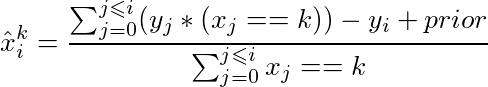

> To prevent overfitting, the process of target encoding for train dataset is repeated several times on shuffled versions of the dataset and results are averaged.

In [ ]:
import category_encoders as ce
cat_cols=['galaxy']
target_enc = ce.CatBoostEncoder(cols=cat_cols)
target_enc.fit(train[cat_cols], train['y'])
train = train.join(target_enc.transform(train[cat_cols]).add_suffix('_cb'))

test = test.join(target_enc.transform(test[cat_cols]).add_suffix('_cb'))
train[['galaxy', 'galaxy_cb']]

*Perhaps we underestimated the importance of working with galaxies. We tried to group by galaxy names (highlight the first word in the name, it is the key), but the result has become worse.*

# Train and Test distribution

After we filled in the missing data, we need to **check the distribution of the training and test dataset**. Perhaps there will be discrepancies. (It turned out too many graphs, because we will show an example of one function).

In [ ]:
sns.distplot(train['Gross income per capita'], label='train')
sns.distplot(test['Gross income per capita'], label='test')
plt.title('Train & Test Distribution')
plt.legend()
plt.show()

On many charts, you can see quite long right tails. We will talk about this in the second part. Also take a look at the distribution of the target and see a similar picture. This is bad for the model learning phase. We will try to avoid these problems in the second part.

In [ ]:
sns.distplot(train['y'], label='train')
plt.title('Target Distribution')

The first part is over! Continued [here](https://www.kaggle.com/imgremlin/prohack-part-2-fe-modeling-optimization)